## **Importing Modules**

In [1]:
pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: C:\Users\dell\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
#importing required modules

import zipfile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import torchvision.models as models
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets, transforms as T
from torch.utils.data import Dataset, DataLoader

import os
import torch.optim as optim
from PIL import ImageFile

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve


## **Data Preprocessing**

In [3]:
#importing data

# #Dataset address
# url = 'https://drive.google.com/uc?export=download&id=1B75cOYH7VCaiqdeQYvMuUuy_Mn_5tPMY'
# output = 'data.zip'
# # gdown.download(url, output, quiet=False)

# #giving zip file name
# data_dir='./data.zip'

# #extractng data from zip file
# with zipfile.ZipFile(data_dir, 'r') as zf:
#     zf.extractall('./data')
#     print('Done downloading and extraction')

# #removing zip file after extraction
# !rm './data.zip' 

#invstigating number of files
cactus_files = np.array(glob("./split/*/*/*"))
print('There are %d total  images.' % len(cactus_files))

#checking the availability of a GPU
use_cuda = torch.cuda.is_available()

There are 17500 total  images.


In [4]:
use_cuda = torch.cuda.is_available()

In [5]:
use_cuda

True

In [6]:
transform = T.Compose([T.ToTensor(),])
data_file='./split/'

train_path=os.path.join(data_file,'train')
dataset = datasets.ImageFolder(train_path,transform=transform)
dataloader = DataLoader(dataset, batch_size=1, num_workers=1, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    if (i == 0): size = data.size(1) * data.size(2)
    mean += data.sum((1, 2)) / size

mean /= len(dataloader)
print(mean)
mean = mean.unsqueeze(1).unsqueeze(2)

for i, data in enumerate(dataloader):
    if (i % 10000 == 0): print(i)
    data = data[0].squeeze(0)
    std += ((data - mean) ** 2).sum((1, 2)) / size

std /= len(dataloader)
std = std.sqrt()
print(std)

0
10000
tensor([0.5034, 0.4517, 0.4681])
0
10000
tensor([0.1511, 0.1398, 0.1532])


In [7]:
#declaring batch size
batch_size = 128

#applying required transformations on the dataset
img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(32,32)), 
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477]), 
    ]),
    

    'valid':
    T.Compose([
        T.Resize(size=(32,32)),
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477])
    ]),


    'test':
    T.Compose([
        T.Resize(size=(32,32)),
        T.ToTensor(),
        T.Normalize([0.5219, 0.5220, 0.5223], [0.2476, 0.2476, 0.2477])
    ]),
}



train_path=os.path.join(data_file,'train')
valid_path=os.path.join(data_file,'test')
test_path=os.path.join(data_file,'valid')


# creating datasets to each of  folder created in prev
train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
valid_file=datasets.ImageFolder(valid_path,transform=img_transforms['valid'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])


#creating loaders for the dataset
loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

## **Model Building**

In [8]:
# Importing the pretrained model
model_transfer = models.resnet50(pretrained=True)

# Freeze weights
for param in model_transfer.parameters():
    param.requires_grad = False

n_inputs = model_transfer.fc.in_features

#Replacing the top dense layers with self defined trainable layers
model_transfer.fc = nn.Sequential(
    nn.Linear(n_inputs, 1024),
    nn.LeakyReLU(inplace = True),

    nn.Linear(1024,512),
    nn.LeakyReLU(inplace=True),
            
    nn.Linear(512,256),
    nn.LeakyReLU(inplace=True),

    nn.Linear(256,64),
    nn.LeakyReLU(inplace=True),

    nn.Linear(64,16),
    nn.LeakyReLU(inplace=True),

    nn.Linear(16,2),
    nn.Sigmoid()
)

#transferring the model to GPU
if use_cuda:
    model_transfer = model_transfer.cuda()

C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dell\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
summary(model_transfer, (3, 224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [10]:
# Assuming `train_dataset` contains your training data
class_counts = np.bincount(train_file.targets)  # Get counts per class
class_weights = 1. / class_counts  # Inverse frequency weighting
class_weights = class_weights / class_weights.sum()  # Normalize

# Convert to tensor and move to GPU if needed
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
if use_cuda:
    class_weights_tensor = class_weights_tensor.cuda()

# Initialize weighted loss function
criterion_transfer = nn.CrossEntropyLoss(weight=class_weights_tensor)

#using Adam optimizer
optimizer_transfer = optim.Adam(model_transfer.fc.parameters(), lr=0.0005)

In [11]:
class_counts

array([9195, 3055], dtype=int64)

In [12]:
class_weights

array([0.24938776, 0.75061224])

## **Training and Validating the Model**



In [13]:
use_cuda

True

In [14]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Creating the function for training
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    trainingloss = []
    validationloss = []

    for epoch in range(1, n_epochs+1):
        # initialize the variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct1 = 0.
        total1 = 0.
        correct2 = 0.
        total2 = 0.

        ###################
        # training the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
          
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            
            loss.backward()
            optimizer.step()
           
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct1 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total1 += data.size(0)

       
        ######################    
        # validating the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            # compare predictions
            correct2 += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total2 += data.size(0)

      

        # train_loss = train_loss/len(train_file)
        # valid_loss = valid_loss/len(valid_file)

        trainingloss.append(train_loss)
        validationloss.append(valid_loss)
        acc1 = 100. * correct1 / total1
        acc2 =  100. * correct2 / total2
        # printing training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.4f}'.format(
            epoch,
            train_loss,
            acc1,
            valid_loss,
            acc2
            ))
        
        ## saving the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            
            valid_loss_min = valid_loss
            
    # return trained model
    return model, trainingloss, validationloss

In [15]:
# training the model

n_epochs=500

model_transfer, train_loss, valid_loss = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 0.439799 	Training Accuracy: 89.7714 	Validation Loss: 0.389825 	Validation Accuracy: 94.3619
Validation loss decreased (inf --> 0.389825).  Saving model ...
Epoch: 2 	Training Loss: 0.386976 	Training Accuracy: 92.2367 	Validation Loss: 0.387464 	Validation Accuracy: 90.7810
Validation loss decreased (0.389825 --> 0.387464).  Saving model ...
Epoch: 3 	Training Loss: 0.380741 	Training Accuracy: 92.6857 	Validation Loss: 0.375164 	Validation Accuracy: 93.2952
Validation loss decreased (0.387464 --> 0.375164).  Saving model ...
Epoch: 4 	Training Loss: 0.382200 	Training Accuracy: 92.3265 	Validation Loss: 0.369885 	Validation Accuracy: 93.1048
Validation loss decreased (0.375164 --> 0.369885).  Saving model ...
Epoch: 5 	Training Loss: 0.372652 	Training Accuracy: 93.5837 	Validation Loss: 0.382604 	Validation Accuracy: 94.6286
Epoch: 6 	Training Loss: 0.369125 	Training Accuracy: 94.1061 	Validation Loss: 0.369434 	Validation Accuracy: 93.5619
Validation loss

In [16]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [26]:
train_loss

[tensor(0.4398, device='cuda:0'),
 tensor(0.3870, device='cuda:0'),
 tensor(0.3807, device='cuda:0'),
 tensor(0.3822, device='cuda:0'),
 tensor(0.3727, device='cuda:0'),
 tensor(0.3691, device='cuda:0'),
 tensor(0.3692, device='cuda:0'),
 tensor(0.3645, device='cuda:0'),
 tensor(0.3717, device='cuda:0'),
 tensor(0.3599, device='cuda:0'),
 tensor(0.3596, device='cuda:0'),
 tensor(0.3586, device='cuda:0'),
 tensor(0.3586, device='cuda:0'),
 tensor(0.3554, device='cuda:0'),
 tensor(0.3534, device='cuda:0'),
 tensor(0.3554, device='cuda:0'),
 tensor(0.3510, device='cuda:0'),
 tensor(0.3606, device='cuda:0'),
 tensor(0.3515, device='cuda:0'),
 tensor(0.3531, device='cuda:0'),
 tensor(0.3541, device='cuda:0'),
 tensor(0.3509, device='cuda:0'),
 tensor(0.3471, device='cuda:0'),
 tensor(0.3433, device='cuda:0'),
 tensor(0.3503, device='cuda:0'),
 tensor(0.3425, device='cuda:0'),
 tensor(0.3446, device='cuda:0'),
 tensor(0.3499, device='cuda:0'),
 tensor(0.3416, device='cuda:0'),
 tensor(0.3415

##  **Testing the Model**



In [17]:
# Defining the test function

def test(loaders, model, criterion, use_cuda):

    # monitoring test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # moving to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # updating average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # converting the output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        # compare predictions
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    # print('Test Loss: {:.7f}\n'.format(test_loss))

    # print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
    #     100. * correct / total, correct, total))
    
    return preds, targets

# calling test function
preds, targets = test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

## **Visulizing the results**

In [18]:
#converting the tensor object to a list for metric functions

preds2, targets2 = [],[]

for i in preds:
  for j in range(len(i)):
    preds2.append(i.cpu().numpy()[j])
for i in targets:
  for j in range(len(i)):
    targets2.append(i.cpu().numpy()[j])

Confusion Matrix:
 [[1924   41]
 [  46  614]]


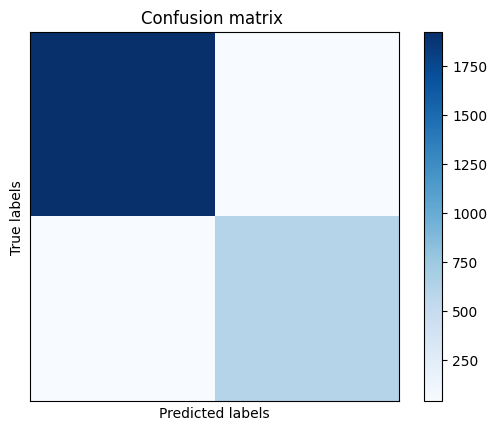

In [19]:
#plotting the confusion matrix for testing data

cm = confusion_matrix(preds2, targets2)
print('Confusion Matrix:\n', cm)
plt.imshow(cm, cmap = plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

AUC score:  0.9570271631727826
Accuracy:  0.9668571428571429
F1 score:  0.9338403041825095
Precision score:  0.9303030303030303
Recall score:  0.9374045801526718


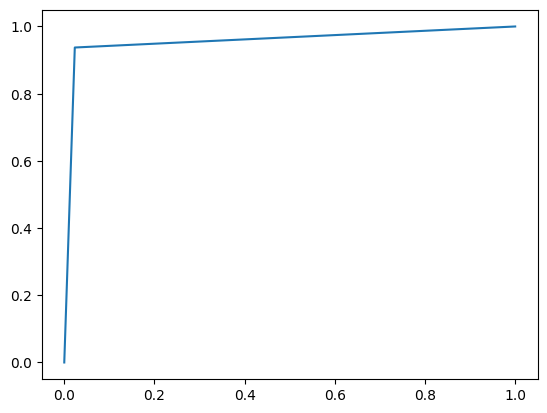

In [20]:
#Computing the 5 evaluation metrics and printing

acc = accuracy_score(targets2, preds2)

fpr, tpr, _ = roc_curve(targets2, preds2)

area = roc_auc_score(targets2, preds2)
print("AUC score: ", area)

print("Accuracy: ", acc)

f1 = f1_score(targets2, preds2)
print("F1 score: ", f1)

pre = precision_score(targets2, preds2)
print("Precision score: ", pre)

recall = recall_score(targets2, preds2)
print("Recall score: ", recall)

plt.plot(fpr, tpr)

Text(0, 0.5, 'loss')

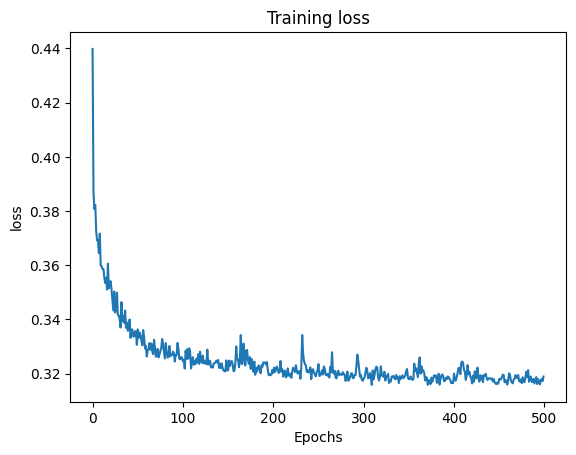

In [28]:
#Plotting the training loss
train_loss_cpu = [loss.item() for loss in train_loss]

plt.plot(train_loss_cpu)
plt.title("Training loss")
plt.xlabel('Epochs')
plt.ylabel("loss")

Text(0, 0.5, 'loss')

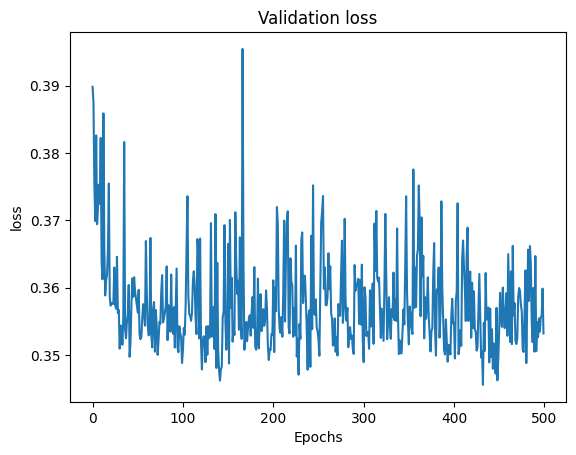

In [30]:
#Plotting the validation loss
val_loss_cpu = [loss.item() for loss in valid_loss]

plt.plot(val_loss_cpu)
plt.title("Validation loss")
plt.xlabel('Epochs')
plt.ylabel("loss")